### Imports

This notebook uses cutting-edge functionality and depends on a recent (`>= 0.7.0-dev`) version of TFP. In Google Colab, you can install the latest release of `tfp-nightly` by uncommenting the following line:

In [2]:
# !pip install --upgrade tf-nightly tfp-nightly
# !pip install matplotlib seaborn
# !pip install tensorflow_probability

Requirement already up-to-date: tf-nightly in /anaconda3/envs/prob/lib/python3.6/site-packages (1.15.0.dev20190821)
Requirement already up-to-date: tfp-nightly in /anaconda3/envs/prob/lib/python3.6/site-packages (0.9.0.dev20190918)


In [29]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import datetime
import collections
import pprint
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import tensorflow as tf

import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

### Plotting setup

Helper methods for plotting time series and forecasts.

In [30]:
sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

In [31]:
def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
  """Plot the contributions of posterior components in a single figure."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  axes_dict = collections.OrderedDict()
  num_components = len(component_means_dict)
  fig = plt.figure(figsize=(12, 2.5 * num_components))
  for i, component_name in enumerate(component_means_dict.keys()):
    component_mean = component_means_dict[component_name]
    component_stddev = component_stddevs_dict[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(dates, component_mean, lw=2)
    ax.fill_between(dates,
                     component_mean-2*component_stddev,
                     component_mean+2*component_stddev,
                     color=c2, alpha=0.5)
    ax.set_title(component_name)
    if x_locator is not None:
      ax.xaxis.set_major_locator(x_locator)
      ax.xaxis.set_major_formatter(x_formatter)
    axes_dict[component_name] = ax
  fig.autofmt_xdate()
  fig.tight_layout()
  return fig, axes_dict

In [32]:
def plot_one_step_predictive(dates, observed_time_series,
                             one_step_mean, one_step_scale,
                             x_locator=None, x_formatter=None):
  """Plot a time series against a model's one-step predictions."""

  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  fig=plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1,1,1)
  num_timesteps = one_step_mean.shape[-1]
  ax.plot(dates, observed_time_series, label="observed time series", color=c1)
  ax.plot(dates, one_step_mean, label="one-step prediction", color=c2)
  ax.fill_between(dates,
                  one_step_mean - one_step_scale,
                  one_step_mean + one_step_scale,
                  alpha=0.1, color=c2)
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()
  fig.tight_layout()
  return fig, ax

In [33]:
def add_freq(idx, freq=None):
    """Add a frequency attribute to idx, through inference or directly.

    Returns a copy.  If `freq` is None, it is inferred.
    """

    idx = idx.copy()
    if freq is None:
        if idx.freq is None:
            freq = pd.infer_freq(idx)
        else:
            return idx
    idx.freq = pd.tseries.frequencies.to_offset(freq)
    if idx.freq is None:
        raise AttributeError('no discernible frequency found to `idx`.  Specify'
                             ' a frequency string with `freq`.')
    return idx

### Data

In [34]:
#https://www.dukascopy.com/swiss/english/marketwatch/historical/
#df = pd.read_csv('../../../datasets/EURUSD_Candlestick_1_Hour_BID_01.01.2012-13.09.2019.csv')
df = pd.read_csv('../../../datasets/EURUSD_Candlestick_1_Hour_BID_31.08.2011-13.09.2019.csv')


In [144]:
#limit to last 10k entries for quick testing
#df = df[-200:]
#df = df.reset_index()

In [35]:
df['my_dates'] = pd.to_datetime(df['Gmt time'], dayfirst=True)
df['my_dates'] = add_freq(df['my_dates'], freq='1H')

df['day_of_week'] = df['my_dates'].dt

In [180]:
#minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
#df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
#df_log = pd.DataFrame(df_log)
#df_log.head()
#df['my_dates'].values

array(['2011-09-01T00:00:00.000000000', '2011-09-01T01:00:00.000000000',
       '2011-09-01T02:00:00.000000000', ...,
       '2019-09-13T18:00:00.000000000', '2019-09-13T19:00:00.000000000',
       '2019-09-13T20:00:00.000000000'], dtype='datetime64[ns]')

In [36]:
num_forecast_steps = 24 # 24 hours

filtered_df = df

close = filtered_df.Close.values.tolist()


#demand_dates = pd.bdate_range(filtered_df.my_dates.iloc[0], filtered_df.my_dates.iloc[-1], freq='H')
demand_dates = df['my_dates'].tolist()
#dd_df = pd.DataFrame(demand_dates)
#demand_dates = demand_dates[dd_df.index.dayofweek <5]
#demand_dates = my_dates[my_dates.dt.dayofweek < 5]

#demand_dates = np.arange(demand_dates[:1].value, demand_dates[-1:].value, dtype='datetime64[h]')
demand_loc = mdates.WeekdayLocator(byweekday=mdates.WE)
demand_fmt = mdates.DateFormatter('%a-%b-%d %H:%M:%S')

demand_training_data = filtered_df[:-num_forecast_steps].Close.values.tolist()

In [37]:
#dd_df = pd.DataFrame(demand_dates)
#demand_dates = demand_dates[dd_df.index.dayofweek <5]
#demand_dates = my_dates[my_dates.dt.dayofweek < 5]

//anaconda3/envs/prob/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Close')

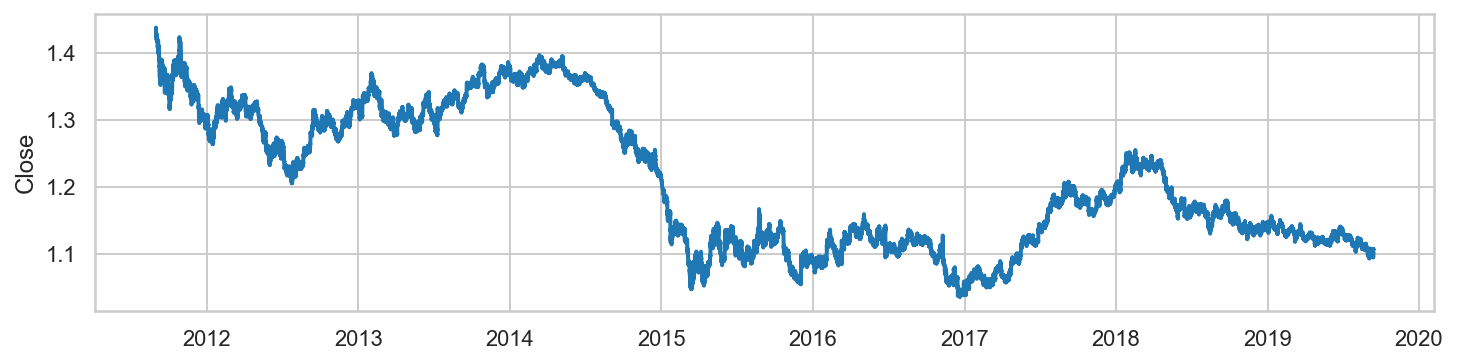

In [38]:
colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(demand_dates[:-num_forecast_steps],
        close[:-num_forecast_steps], lw=2, label="training data")
ax.set_ylabel("Close")



### Model and fitting

Our model combines a hour-of-day and day-of-week seasonality, with a linear regression modeling the effect of temperature, and an autoregressive process to handle bounded-variance residuals.

In [39]:
def build_model(observed_time_series):
  hour_of_day_effect = sts.Seasonal(
      num_seasons=24,
      observed_time_series=observed_time_series,
      name='hour_of_day_effect')
  day_of_week_effect = sts.Seasonal(
      num_seasons=5, num_steps_per_season=24,
      observed_time_series=observed_time_series,
      name='day_of_week_effect')
#   temperature_effect = sts.LinearRegression(
#       design_matrix=tf.reshape(temperature - np.mean(temperature),
#                                (-1, 1)), name='temperature_effect')
  autoregressive = sts.Autoregressive(
      order=1,
      observed_time_series=observed_time_series,
      name='autoregressive')
  model = sts.Sum([hour_of_day_effect,
                   day_of_week_effect,
                   autoregressive],
                   observed_time_series=observed_time_series)
  return model

As above, we'll fit the model with variational inference and draw samples from the posterior.

In [40]:
#tf.reset_default_graph()
tf.reset_default_graph()
demand_model = build_model(demand_training_data)

# Build the variational loss function and surrogate posteriors `qs`.
with tf.variable_scope('sts_elbo', reuse=tf.AUTO_REUSE):
  elbo_loss, variational_posteriors = tfp.sts.build_factored_variational_loss(
      demand_model, demand_training_data)
train_vi = tf.train.AdamOptimizer(0.1).minimize(elbo_loss)

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Instructions for updating:
`tfp.sts.build_factored_variational_loss` is deprecated. Use`tfp.sts.build_factored_surrogate_posterior` and `tfp.vi.monte_carlo_variational_loss` (or `tfp.vi.fit_surrogate_posterior` to automate the optimization loop) instead.
Instructions for updating:
SeedStream has moved to `tfp.util.SeedStream`.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [41]:
# Run the optimization and draw samples from the surrogate posteriors.

# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 20  # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  for i in range(num_variational_steps):
    _, elbo_ = sess.run((train_vi, elbo_loss))
    if i % 20 == 0:
      print("step {} -ELBO {}".format(i, elbo_))

  q_samples_demand_ = sess.run({k: q.sample(50)
                                for k, q in variational_posteriors.items()})

step 0 -ELBO -17656.708984375


In [42]:
print("Inferred parameters:")
for param in demand_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_demand_[param.name], axis=0),
                              np.std(q_samples_demand_[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 0.06615528464317322 +- 0.0006357536185532808
hour_of_day_effect/_drift_scale: 0.004477080889046192 +- 7.668614125577733e-05
day_of_week_effect/_drift_scale: 0.2734609544277191 +- 0.001865388359874487
autoregressive/_coefficients: [0.02127682] +- [0.01358402]
autoregressive/_level_scale: 0.024590497836470604 +- 0.00038669357309117913


### Forecasting and criticism

Again, we create a forecast simply by calling `tfp.sts.forecast` with our model, time series, and sampled parameters.

In [43]:
demand_forecast_dist = tfp.sts.forecast(
    model=demand_model,
    observed_time_series=demand_training_data,
    parameter_samples=q_samples_demand_,
    num_steps_forecast=num_forecast_steps)

In [44]:
num_samples=24

with tf.Session() as sess:
  (demand_forecast_mean,
   demand_forecast_scale,
   demand_forecast_samples) = sess.run(
      (demand_forecast_dist.mean()[..., 0],
       demand_forecast_dist.stddev()[..., 0],
       demand_forecast_dist.sample(num_samples)[..., 0]))

[   Timestamp('2019-09-10 21:00:00'),
    Timestamp('2019-09-10 22:00:00'),
    Timestamp('2019-09-10 23:00:00'),
    Timestamp('2019-09-11 00:00:00'),
    Timestamp('2019-09-11 01:00:00'),
    Timestamp('2019-09-11 02:00:00'),
    Timestamp('2019-09-11 03:00:00'),
    Timestamp('2019-09-11 04:00:00'),
    Timestamp('2019-09-11 05:00:00'),
    Timestamp('2019-09-11 06:00:00'),
    Timestamp('2019-09-11 07:00:00'),
    Timestamp('2019-09-11 08:00:00'),
    Timestamp('2019-09-11 09:00:00'),
    Timestamp('2019-09-11 10:00:00'),
    Timestamp('2019-09-11 11:00:00'),
    Timestamp('2019-09-11 12:00:00'),
    Timestamp('2019-09-11 13:00:00'),
    Timestamp('2019-09-11 14:00:00'),
    Timestamp('2019-09-11 15:00:00'),
    Timestamp('2019-09-11 16:00:00'),
    Timestamp('2019-09-11 17:00:00'),
    Timestamp('2019-09-11 18:00:00'),
    Timestamp('2019-09-11 19:00:00'),
    Timestamp('2019-09-11 20:00:00'),
    Timestamp('2019-09-11 21:00:00'),
    Timestamp('2019-09-11 22:00:00'),
    Timestam

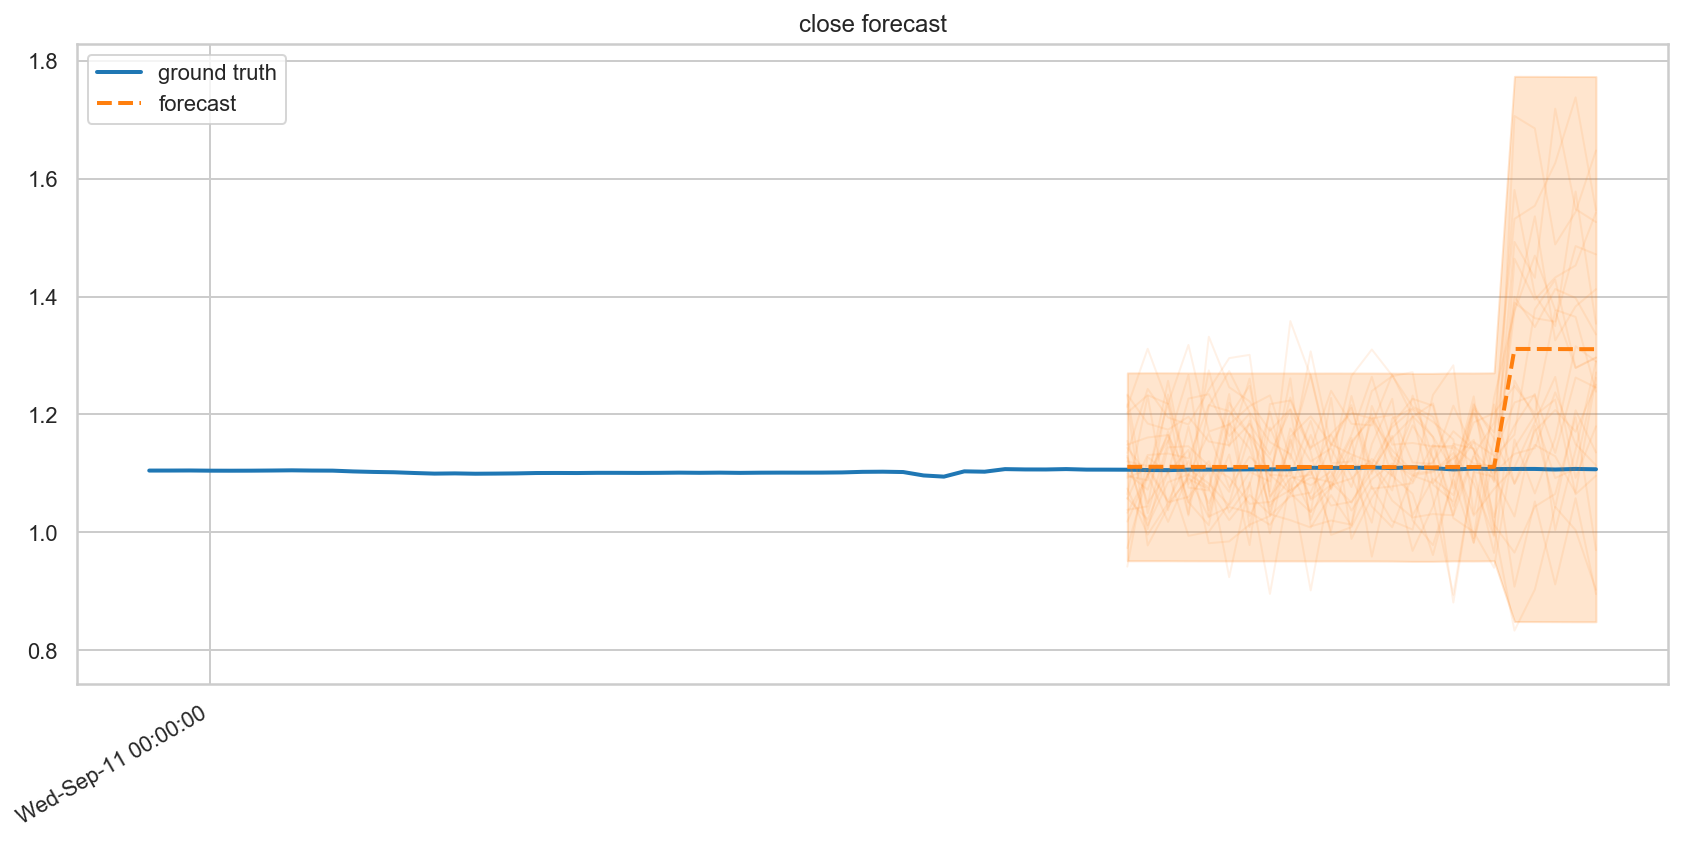

In [45]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
  """Plot a forecast distribution against the 'true' time series."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1, 1, 1)

  num_steps = len(y)
  num_steps_forecast = forecast_mean.shape[-1]
  num_steps_train = num_steps - num_steps_forecast


  ax.plot(x, y, lw=2, color=c1, label='ground truth')


  #forecast_steps = np.arange(
   #   x[num_steps_train],
    #  x[num_steps_train]+num_steps_forecast,
     # datetime.timedelta(hours=1),
      # dtype='datetime64[h]'
       #)
  #print([x[num_steps_train] + datetime.timedelta(hours=1) for i in range(num_steps_train)])

  start_date = x[num_steps_train]
  
  forcast_dates = [start_date]
  for i in range(forecast_mean.shape[-1]-1):
     forcast_dates.append( forcast_dates[-1] + datetime.timedelta(hours=1) ) 
  forecast_steps = forcast_dates
  pp.pprint(forecast_steps)
  #forecast_steps = np.array([x[num_steps_train] + datetime.timedelta(hours=1) for i in range(num_steps_train)])

  ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')
  ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

  ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_title("{}".format(title))
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax


frame = num_forecast_steps * 3

pp.pprint(demand_dates[-frame:])
fig, ax = plot_forecast(demand_dates[-frame:],
                        close[-frame:],
                        demand_forecast_mean,
                        demand_forecast_scale,
                        demand_forecast_samples,
                        title = "close forecast",
                        x_locator=demand_loc,
                        x_formatter=demand_fmt)

#ax.set_ylim([1.09, 1.145])

fig.tight_layout()

Let's visualize the decomposition of the observed and forecast series into the individual components:

Timestamp('2019-09-13 20:00:00')

In [194]:
# Get the distributions over component outputs from the posterior marginals on
# training data, and from the forecast model.
component_dists = sts.decompose_by_component(
    demand_model,
    observed_time_series=demand_training_data,
    parameter_samples=q_samples_demand_)

forecast_component_dists = sts.decompose_forecast_by_component(
    demand_model,
    forecast_dist=demand_forecast_dist,
    parameter_samples=q_samples_demand_)

In [195]:
with tf.Session() as sess:
  demand_component_means_, demand_component_stddevs_ = sess.run(
      [{k.name: c.mean() for k, c in component_dists.items()},
       {k.name: c.stddev() for k, c in component_dists.items()}])

  [
      demand_forecast_component_means_,
      demand_forecast_component_stddevs_
  ] = sess.run(
      [{k.name: c.mean() for k, c in forecast_component_dists.items()},
       {k.name: c.stddev() for k, c in forecast_component_dists.items()}])

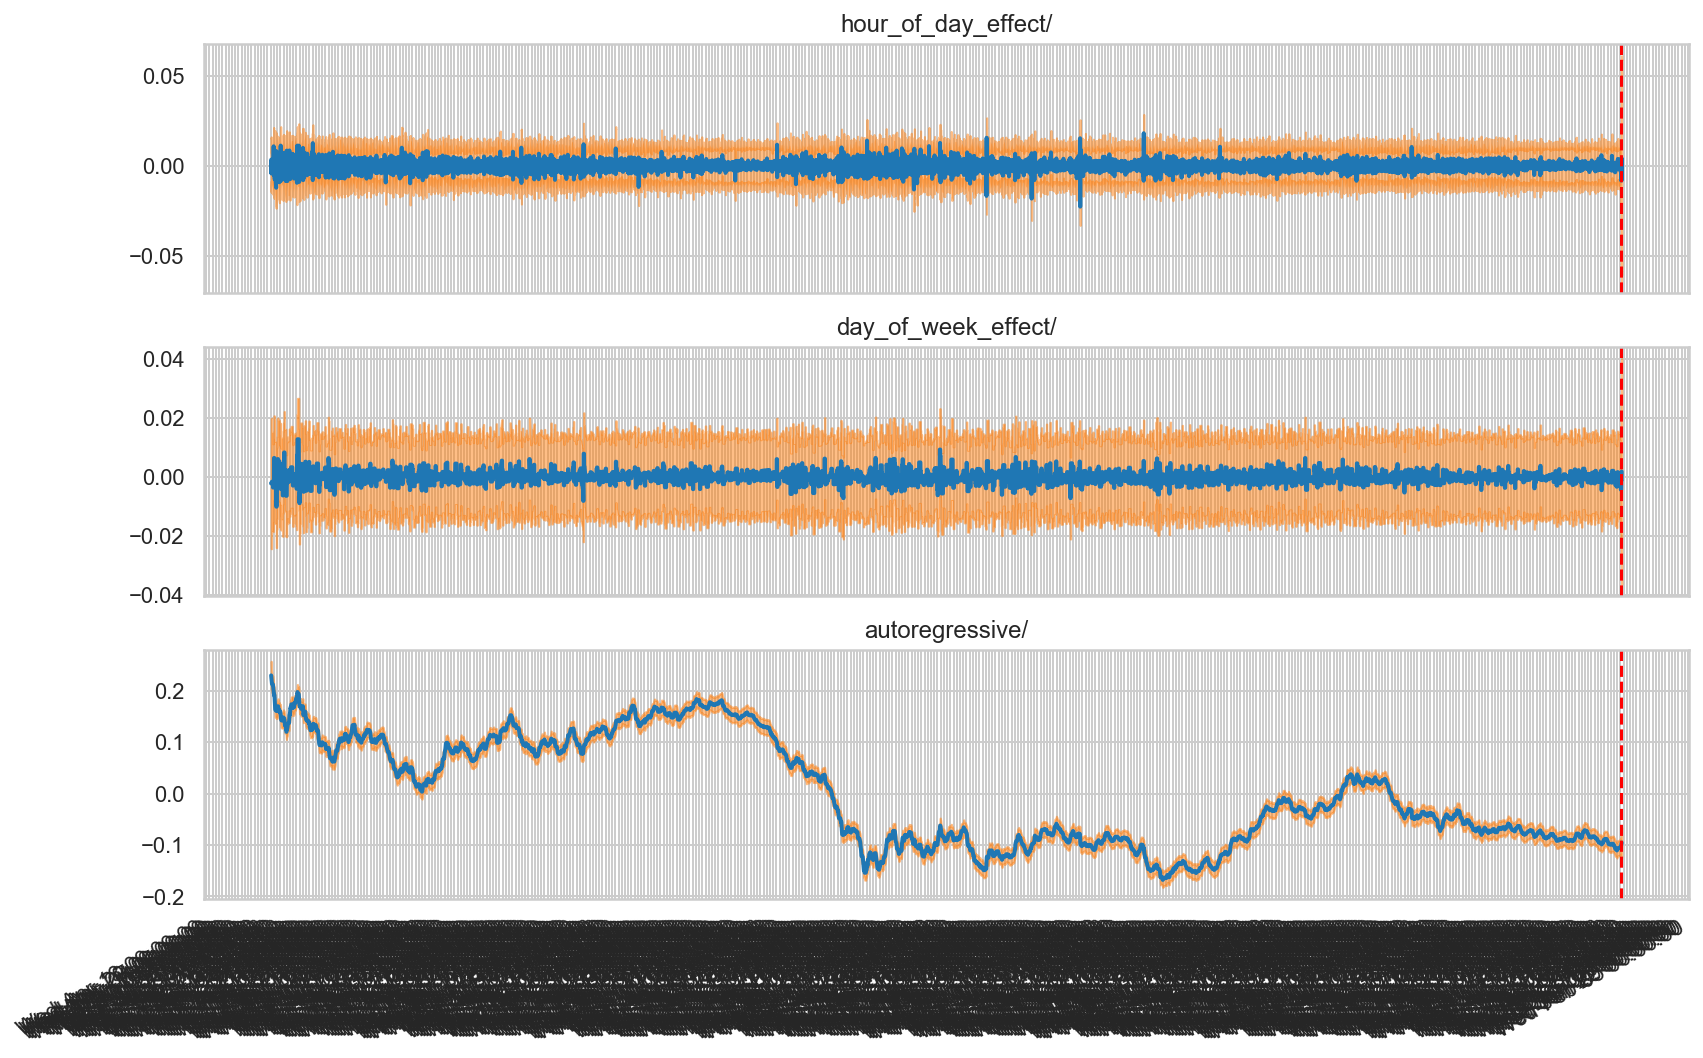

In [227]:
# Concatenate the training data with forecasts for plotting.
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
for k in demand_component_means_.keys():
  component_with_forecast_means_[k] = np.concatenate([
      demand_component_means_[k],
      demand_forecast_component_means_[k]], axis=-1)
  component_with_forecast_stddevs_[k] = np.concatenate([
      demand_component_stddevs_[k],
      demand_forecast_component_stddevs_[k]], axis=-1)


fig, axes = plot_components(
  demand_dates,
  component_with_forecast_means_,
  component_with_forecast_stddevs_,
  x_locator=demand_loc, x_formatter=demand_fmt)
for ax in axes.values():
  ax.axvline(demand_dates[-num_forecast_steps], linestyle="--", color='red')

If we wanted to detect anomalies in the observed series, we might also be interested in the one-step predictive distributions: the forecast for each timestep, given only the timesteps up to that point. `tfp.sts.one_step_predictive` computes all of the one-step predictive distributions in a single pass:

In [197]:
demand_one_step_dist = sts.one_step_predictive(
    demand_model,
    observed_time_series=close,
    parameter_samples=q_samples_demand_)

with tf.Session() as sess:
  demand_one_step_mean = sess.run(demand_one_step_dist.mean())
  demand_one_step_scale = sess.run(demand_one_step_dist.stddev())

A simple anomaly detection scheme is to flag all timesteps where the observations are more than three stddevs from the predicted value -- these are the most 'surprising' timesteps according to the model.

In [46]:

fig, ax = plot_one_step_predictive(
    demand_dates[-frame:],
    close[-frame:],
    demand_one_step_mean[-frame:],
    demand_one_step_scale[-frame:],
    x_locator=demand_loc,
    x_formatter=demand_fmt)

ax.set_ylim(1.1, 1.2)

# Use the one-step-ahead forecasts to detect anomalous timesteps.
zscores = np.abs((close - demand_one_step_mean) /
                 demand_one_step_scale)
anomalies = zscores > 3.0

ax.scatter(demand_dates[-frame:][anomalies[0]],
           close[-frame:][anomalies[0]],
           #demand_dates[anomalies[0]],
           #close[anomalies[0]],
           c="red", marker="x", s=20, linewidth=2, label="Anomalies (>3$\sigma$)")
ax.plot(demand_dates[-frame:], zscores[-frame:], color="black", alpha=0.1, label='predictive z-score')
ax.legend()

NameError: name 'demand_one_step_mean' is not defined

In [1]:
#pip install tabula-py
from tabula import read_pdf

#https://www.nadex.com/market-data
pdf = read_pdf("../../../datasets/20190913_timeandsales.pdf", pages='all')

In [2]:
#pdf
#pdf['Instrument'], pdf['Trade'] =

intraday = pdf[(pdf['Periodicity'] == "Intraday") & (pdf['Instrument Type'] == "Binary Option")]

In [3]:
out
#pdf['Instrument'] = out
#pdf
def split_dn(x):
    x = x['Instrument'].split(' ')
    return  ' '.join(z for z in x if z not in stop_words)

NameError: name 'out' is not defined

In [ ]:
#out = pdf['Display Name'].str.split('>')
#intraday
out

In [ ]:

out = intraday['Display Name'].str.split('>').apply(pd.Series)
#out.apply(pd.Series)
intraday['Instrument'] = out[:][0]
out = out[:][1].str.split(' \(').apply(pd.Series)
intraday['bprice'] = out[:][0]
intraday['btime'] = out[:][1].str.replace(')','')

#intraday['Instrument'] = out

#out = intraday['Instrument'].str.split(',')
#intraday[]


In [27]:
type(intraday)

pandas.core.frame.DataFrame

In [28]:
for index, row in intraday.head(n=2).iterrows():
     print(index, row)

2381 Business Date                       09/13/2019
Execution Time     09/13/2019 09:01:33.134 EDT
Instrument Type                  Binary Option
Periodicity                           Intraday
Display Name             AUD/JPY >74.23 (10AM)
Expiration Date           09/13/2019 10:00 EDT
Price (USD)                           83.00000
Volume                                       1
Name: 2381, dtype: object
2382 Business Date                       09/13/2019
Execution Time     09/13/2019 10:05:58.033 EDT
Instrument Type                  Binary Option
Periodicity                           Intraday
Display Name             AUD/JPY >74.23 (12PM)
Expiration Date           09/13/2019 12:00 EDT
Price (USD)                           86.25000
Volume                                       1
Name: 2382, dtype: object


In [44]:
def 

Series([], Name: Display Name, dtype: object)

ValueError: Unexpected per-op iterator flag "REFS_OK"